In [148]:
using FITSIO, PyPlot, Interpolations, Optim, ForwardDiff

# load 3D grid

In [12]:
grid = FITS(read ∘ first, "grid_files/am03cm10np05vp12.fits");
wls = (10 .^ range(log10(15100.802); step=6e-6, length=size(grid, 1)))

@assert all(isnan.(grid), dims=[2, 3, 4]) == any(isnan.(grid), dims=[2, 3, 4])
mask = .! any(isnan.(grid), dims=[2, 3, 4])[:]

grid = grid[mask, :, :, :];
wls = wls[mask]
;

In [13]:
param_names = ["teff", "logg", "metallicity"]
llimits = [3500., 0., -2.5]
steps   = [250, 0.5, 0.25]
ulimits = [6250, 5.0, 1.25]
ranges = (:).(llimits, steps, ulimits .- steps)

3-element Array{StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}},1}:
 3500.0:250.0:6000.0
 0.0:0.5:4.5
 -2.5:0.25:1.0

-----
# Interpolation

## Naive multi-interpolation (separate interpolator for each pixel)
how to make this more efficient? https://github.com/JuliaMath/Interpolations.jl/issues/389

In [14]:
itps = [CubicSplineInterpolation(tuple(ranges...), grid[i, :, :, :]) for i in 1:size(grid, 1)];
interpolate_spectrum(x) = [itp(x...) for itp in itps]
function interpolated_jacobi(x)
    J = Matrix(undef, size(grid, 1), length(x))
    for (λ, itp) in enumerate(itps)
        Interpolations.gradient!(view(J,λ,:), itp, x...)
    end
    J
end

interpolated_jacobi (generic function with 1 method)

  0.895158 seconds (9.77 M allocations: 325.712 MiB, 12.88% gc time)
  

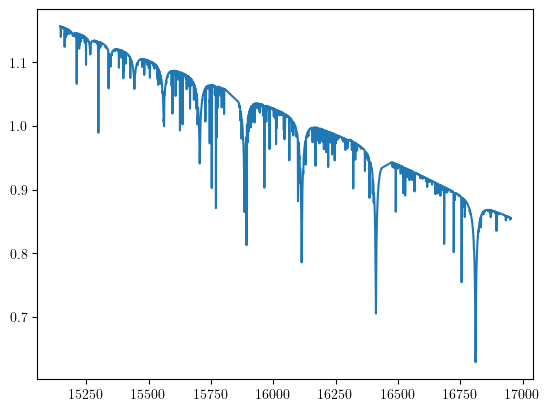

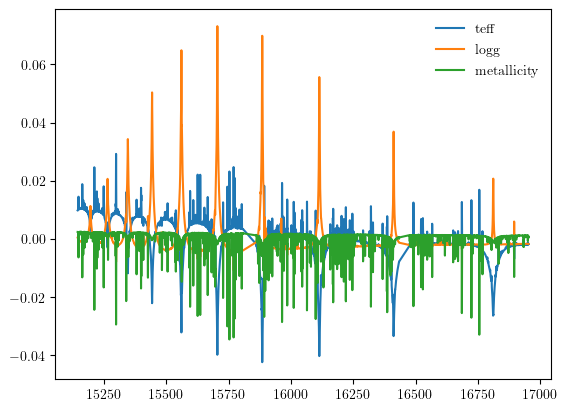

1.118668 seconds (6.72 M allocations: 249.717 MiB, 3.67% gc time)


In [15]:
x = reverse([-1.12, 2.225, 5571.3])
plot(wls, @time interpolate_spectrum(x))

figure()
lines = plot(wls, (@time interpolated_jacobi(x)).* steps')
legend(lines, param_names)
;

## multi-interpolation with a custom type

In [6]:
struct NVec{F, N}
    data :: Vector{F}
end

In [7]:
Base.:+(x::NVec{F, N}, y::NVec{F, N}) where F where N = NVec{F, N}(x.data .+ y.data)
Base.:-(x::NVec{F, N}, y::NVec{F, N}) where F where N = NVec{F, N}(x.data .- y.data)

Base.:*(x::NVec{F, N}, y::NVec{F, N}) where F where N = NVec{F, N}(x.data .* y.data)
Base.:*(x::Real, y::NVec{F, N}) where F where N = NVec{F, N}(x .* y.data)
Base.:*(x::NVec{F, N}, y::Real) where F where N = NVec{F, N}(x.data .* y)

Base.:/(x::NVec{F, N}, y::Real) where F where N = NVec{F, N}(x.data ./ y)

Base.zero(::Type{NVec{F, N}}) where F where N = NVec{F, N}(zeros(F, N))

In [81]:
param_inds = CartesianIndices(size(grid)[2:end])
g = [NVec{Float32, size(grid, 1)}(grid[ :, ii]) for ii in param_inds];
itp = CubicSplineInterpolation(tuple(ranges...), g);

In [80]:
@time interpolated_jacobi(x);
@time Interpolations.gradient(itp, x...)
;

  0.011755 seconds (115.79 k allocations: 3.246 MiB)
  0.011010 seconds (1.40 k allocations: 28.294 MiB)


It's slower :(  Perhaps if I could figure out how to tell the compiler that the grid is static get it all into one memory block...

## multi-interpolation with StaticArrays - compile time is prohibitive

don't execute this cell unless you want to watch your computer compile forever

In [ ]:
using StaticArrays
g = [SVector{size(grid, 1), Float32}(grid[ :, ii]) for ii in param_inds];
itp = CubicSplineInterpolation(tuple(ranges...), g)

------


# inference - now with derivatives

note: `Interpolations.hessian` causes a stack overflow.  I think the problem has something to do with boundary conditions?
https://github.com/JuliaMath/Interpolations.jl/issues/364,  https://github.com/JuliaMath/Interpolations.jl/issues/268

In [149]:
#demo - this doesn't work
Interpolations.hessian(itps[20], p)
#function χ2hessian!(H, params)
#    J = interpolated_jacobi(params)
#    res = (interpolate_spectrum(params) .- f)
#    H = map(1:size(grid, 1)) do λ
#        #Hλ = Interpolations.hessian!(itps[λ], params)
#        #2/err[λ]^2 * (J[λ]*J[λ]' + res[λ] * Hλ)
#        zeros(3, 3)
#    end |> sum
#end

LoadError: StackOverflowError:

In [163]:
f = interpolate_spectrum([5112.23, 3.34, 0.112])
err = ones(size(f)) * 0.01
f .+= randn(size(f)) .* err

χ2(params) = sum(((interpolate_spectrum(params) .- f) ./ err).^2)
χ2grad(params) = sum( 2 * (interpolate_spectrum(params) .- f) .* interpolated_jacobi(params) ./ err.^2, dims=1)[:]
χ2grad!(G, params) = G .= χ2grad(params)
χ2hessian!(H, params) = ForwardDiff.hessian!(H, χ2, params)

println("no gradient")
@time res = optimize(χ2, llimits, ulimits - steps, [4000., 3., 0.])
println(res.minimizer)

println()
println("analytic gradient")
@time res = optimize(χ2, χ2grad!, llimits, ulimits - steps, [4000., 3., 0.])
println(res.minimizer)

println()
println("analytic gradient and autodiff hessian")
@time res = optimize(χ2, χ2grad!, χ2hessian!, llimits, ulimits - steps, [4000., 3., 0.])
println(res.minimizer)
res

no gradient
 21.158801 seconds (156.16 M allocations: 2.794 GiB, 2.64% gc time)
[5117.487403035016, 3.341297534718204, 0.11162499683680957]

analytic gradient
  2.338455 seconds (27.83 M allocations: 614.459 MiB, 7.76% gc time)
[5117.487402918773, 3.3412975346137324, 0.11162499679123691]

analytic gradient and autodiff hessian
  6.550738 seconds (64.78 M allocations: 1.594 GiB, 5.79% gc time)
[5117.487399412997, 3.3412975290674347, 0.11162499521535472]


 * Status: success

 * Candidate solution
    Final objective value:     7.956120e+03

 * Found with
    Algorithm:     Interior Point Newton

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 1.11e-04 ≰ 1.0e-08

 * Work counters
    Seconds run:   6  (vs limit Inf)
    Iterations:    37
    f(x) calls:    221
    ∇f(x) calls:   221
